In [1]:
basedir = '/home/abhinavgupta0110/NeuralODEs_ROM_Closure'

import os

is_google_colab = False
is_use_GPU = False

In [2]:
if is_use_GPU:
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('No GPU found!')
    else:
        print(gpu_info)

if is_google_colab:
    from google.colab import drive
    drive.mount('/content/drive')

    %pip install quadpy

os.chdir(os.path.join(basedir, 'neuralClosureModels'))

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
from src.utilities.Fixed_step_solvers import fixed_step_solver 
import src.bio_eqn_case.bio_eqn_1D_modcall as bio

import time
from math import *
from IPython.core.debugger import set_trace

import numpy as np
import scipy.interpolate
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

tf.keras.backend.set_floatx('float32')

In [4]:
class initial_cond:

    def __init__(self, app):
        self.app = app

    def __call__(self, t):

        if self.app.bio_model == 'NPZ':
            x0 = [self.app.T_bio - 0.05*2*self.app.T_bio, 0.05 * self.app.T_bio, 0.05 * self.app.T_bio]
        elif self.app.bio_model == 'NNPZD':
            x0 = [self.app.T_bio/2., self.app.T_bio/2. - 3*0.05*self.app.T_bio, 0.05*self.app.T_bio, 0.05*self.app.T_bio, 0.05*self.app.T_bio]
        return tf.expand_dims(tf.concat(x0, axis=0), axis=0)

In [5]:
class custom_plot:

    def __init__(self, z, t, args):
        self.t = t
        self.args = args
        self.T, self.Z = np.meshgrid(t.numpy(), z.numpy())
        self.z = z
        
    def plot_indiv(self, ax, title, B):
        ax.cla()
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('z', fontsize=14)
        ax.set_xlabel('t (days)', fontsize=14)
        plot = ax.contourf(self.T, self.Z, B, cmap=cm.coolwarm,
                           antialiased=False, levels=np.linspace(0, np.max(B.flatten()), 20), extend='min')
        ax.set_ylim(self.z[-1], self.z[0])
        ax.set_xlim(self.t[0], self.t[-1])
        plt.colorbar(plot, ax=ax, shrink=0.5, aspect=10)
        
            
    def plot_npz(self, B):
        fig = plt.figure(figsize=(14, 10), facecolor='white')
        ax_N = fig.add_subplot(221)
        ax_P = fig.add_subplot(222)
        ax_Z = fig.add_subplot(223)
        
        self.plot_indiv(ax_N, 'Nutrients', tf.transpose(tf.squeeze(B[:, :, 0:self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())

        plt.show()
        
    def plot_nnpzd(self, B):
        fig = plt.figure(figsize=(14, 20), facecolor='white')
        ax_NO3 = fig.add_subplot(321)
        ax_NH4 = fig.add_subplot(322)
        ax_P = fig.add_subplot(323)
        ax_Z = fig.add_subplot(324)
        ax_D = fig.add_subplot(325)
        
        self.plot_indiv(ax_NO3, 'Nitrates', tf.transpose(tf.squeeze(B[:, :, 0:self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_NH4, 'Ammonia', tf.transpose(tf.squeeze(B[:, :, self.args.nz:2*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_P, 'Phytoplankton', tf.transpose(tf.squeeze(B[:, :, 2*self.args.nz:3*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_Z, 'Zooplankton', tf.transpose(tf.squeeze(B[:, :, 3*self.args.nz:4*self.args.nz], axis=1)).numpy())
        self.plot_indiv(ax_D, 'Detritus', tf.transpose(tf.squeeze(B[:, :, 4*self.args.nz:5*self.args.nz], axis=1)).numpy())

        plt.show()

In [6]:
class diff_coeff():
    
    def __init__(self, args, M, t, kind = 'linear'):
        self.args = args
        self.M_intrp = scipy.interpolate.interp1d(
            t,  # X
            M,  # Y
            kind=kind, axis=0,
            bounds_error=False,
            fill_value="extrapolate")
        
    def __call__(self, z, t):
        
        Kz = self.args.K_zb + ((self.args.K_z0 - self.args.K_zb) * \
        (np.arctan(self.args.gamma_K * (-(self.M_intrp(t) - z))) \
         - np.arctan(self.args.gamma_K * (-(self.M_intrp(t) - self.args.z_max)))) \
                              / (np.arctan(self.args.gamma_K * (-self.M_intrp(t))) \
                                 - np.arctan(self.args.gamma_K * (-(self.M_intrp(t) - self.args.z_max)))))
        
        return Kz

## NPZ Model

In [7]:
args = bio.bio_eqn_args(T = 10, nt = 10, nz = 50, z_max = -100, k_w = 0.067, alpha = 0.025, V_m = 1.5, I_0 = 158.075, 
                       K_u = 1., Psi = 1.46, Xi = 0.1, R_m = 1.5, Lambda = 0.06, gamma = 0.3, Tau = 0.145, 
                       Phi = 0.175, Omega = 0.041, T_bio_min = 10., T_bio_max = 30., wp = 0.65, wd = 8.0, 
                       bio_model = 'NPZ', K_zb = 0.0864, K_z0 = 100.*0.0864, T_mld = 365)

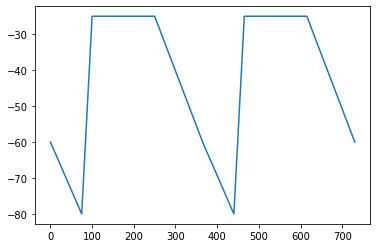

In [8]:
t_M = np.array([0, 75, 100, 250, 365, 365 + 75, 365 + 100, 365 + 250, 365 + 365])
M = np.array([-60., -80., -25., -25., -60., -80., -25., -25., -60.])

plt.plot(t_M, M)

K_z_obj = diff_coeff(args, M, t_M, 'linear')

In [9]:
t = tf.linspace(0., args.T, args.nt) # Time array

In [10]:
x0_low_complex = initial_cond(args)

In [11]:
%time x_npz = ddeinttf(bio.bio_eqn(args, K_z_obj), x0_low_complex, t)

/home/abhinavgupta0110/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: larger nsteps is needed
  self.messages.get(istate, unexpected_istate_msg)))


CPU times: user 6min 30s, sys: 2min 35s, total: 9min 5s
Wall time: 9min 5s


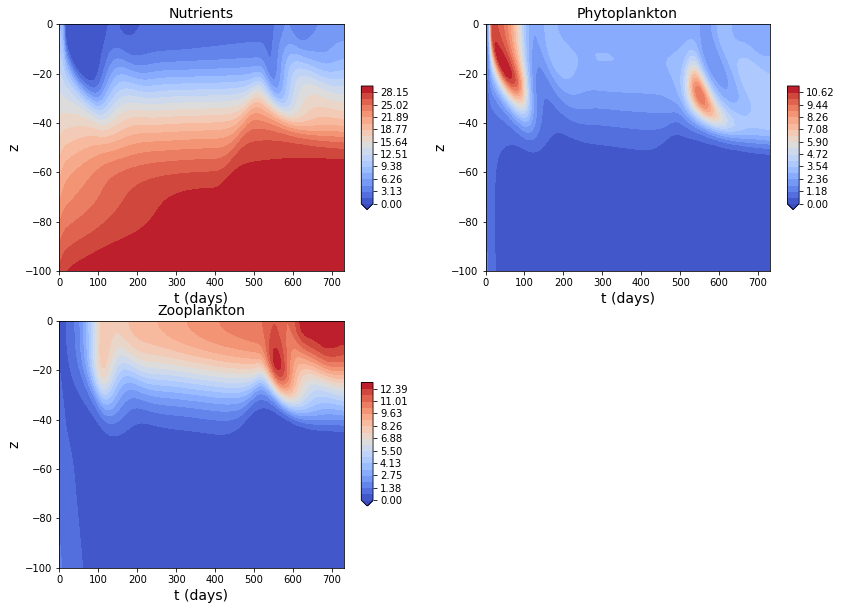

In [12]:
custom_plot(args.z, t, args).plot_npz(x_npz)